In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import numpy as np
import sys
from PIL import Image
from scipy.stats import spearmanr as spr

In [2]:
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from captum.attr import Saliency, IntegratedGradients, LRP, GuidedBackprop, NoiseTunnel, GuidedGradCam, InputXGradient
from captum.attr import visualization as viz

In [4]:
sys.path.append("../attacks/")
from utils import get_expl, torch_to_image, load_image,  convert_relu_to_softplus, heatmap_to_image

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

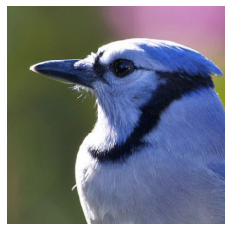

In [6]:
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])
x = load_image(data_mean, data_std, device, "../sample_imagenet/sample_0.jpg")
plt.imshow(torch_to_image(x, data_mean, data_std))
plt.axis('off')
plt.savefig("Original_image", dpi=300, bbox_inches='tight', pad_inches=0.05)

In [7]:
sigma = (torch.max(x) - torch.min(x)).item() * 0.2
sigma

0.9447309494018555

### Cascade randomization of layers

tensor(17, device='cuda:0')


/home/ubuntu/captum/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


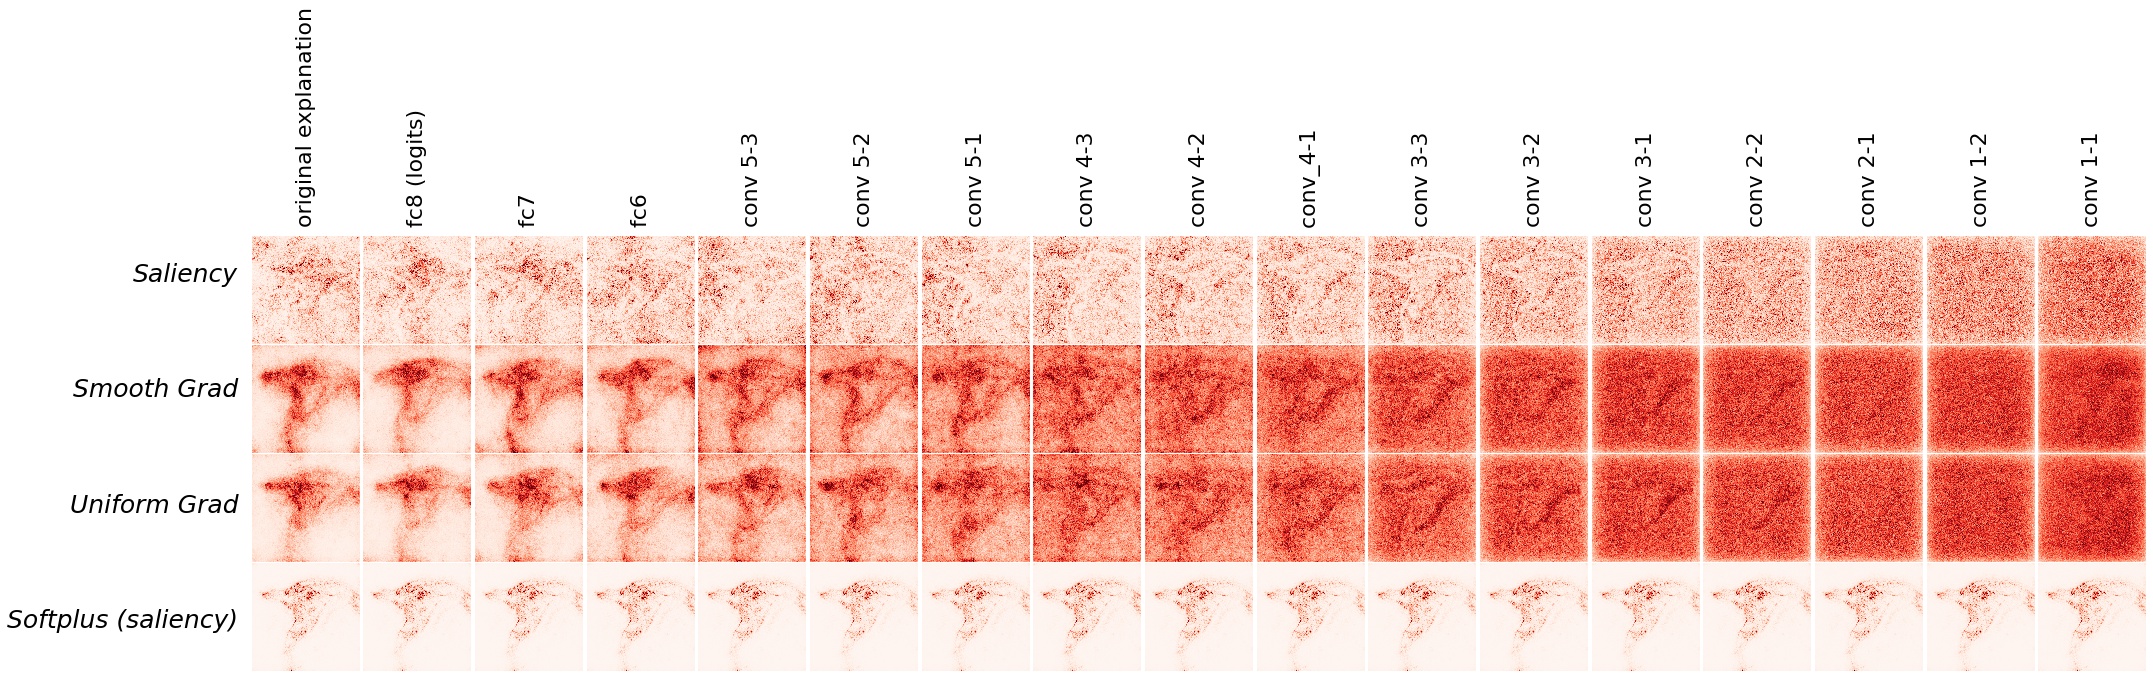

In [8]:
# cascade

layer_names = ["conv 1-1", "conv 1-2", "conv 2-1", "conv 2-2", 
              "conv 3-1", "conv 3-2", "conv 3-3",
              "conv_4-1", "conv 4-2", "conv 4-3",
              "conv 5-1", "conv 5-2", "conv 5-3",
              "fc6", "fc7", "fc8 (logits)", "original explanation"]
layer_names = layer_names[::-1]

model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

idx = model(x).argmax()
print(idx)


x_expl_grad = get_expl(model, x, "saliency", desired_index=idx)
x_expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma)
x_expl_ug = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma)

fig, ax = plt.subplots(4, 17, figsize=(34, 8))
viz.visualize_image_attr(np.transpose(x_expl_grad.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[0, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(x_expl_sg.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(x_expl_ug.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[2, 0]), use_pyplot=False)

org_layers_to_reinit = []
# softplus_layers_to_reinit = []

for i in range(len(model.features)):
    if isinstance(model.features[i], nn.Conv2d):
        org_layers_to_reinit.append(model.features[i])
    elif isinstance(model.features[i], nn.Linear):
        org_layers_to_reinit.append(model.features[i])
    else: pass
    
for i in range(len(model.classifier)):
    if isinstance(model.classifier[i], nn.Conv2d):
        org_layers_to_reinit.append(model.classifier[i])
    elif isinstance(model.classifier[i], nn.Linear):
        org_layers_to_reinit.append(model.classifier[i])
    else: pass
org_layers_to_reinit = org_layers_to_reinit[::-1]

for i, l in enumerate(org_layers_to_reinit):
    nn.init.xavier_uniform_(l.weight)
    x_expl_grad = get_expl(model, x, "saliency", desired_index=idx)
    x_expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma)
    x_expl_ug = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma)

    viz.visualize_image_attr(np.transpose(x_expl_grad.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[0, i+1]), use_pyplot=False)

    viz.visualize_image_attr(np.transpose(x_expl_sg.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1, i+1]), use_pyplot=False)
    
    viz.visualize_image_attr(np.transpose(x_expl_ug.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[2, i+1]), use_pyplot=False)

############softplus###########################
model = torchvision.models.vgg16(pretrained=True).to(device)
model = convert_relu_to_softplus(model, beta=0.8)

x_expl_softplus = get_expl(model, x, "saliency", desired_index=idx)
viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[3, 0]), use_pyplot=False)

for i, l in enumerate(org_layers_to_reinit):
    nn.init.xavier_uniform_(l.weight)
    x_expl_softplus = get_expl(model, x, "saliency", desired_index=idx)
    viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[3, i+1]), use_pyplot=False)
    
    
for i in range(17):
    ax[0, i].set_title(" "+layer_names[i], fontsize=22, rotation=90)
for i in range(4): 
    for j in range(17):
        ax[i,j].axis('off')
fig.text(0.12, 0.8, 'Saliency', style = 'oblique', fontsize = 25, horizontalalignment ='right')
fig.text(0.12, 0.6, 'Smooth Grad', style = 'oblique', fontsize = 25, horizontalalignment ='right')
fig.text(0.12, 0.4, 'Uniform Grad', style = 'oblique', fontsize = 25, horizontalalignment ='right')
fig.text(0.12, 0.2, 'Softplus (saliency)', style = 'oblique', fontsize = 25, horizontalalignment ='right')
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("expls_cascade_randomized.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

#### comparing with spr values

In [13]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

idx = model(x).argmax()
print(idx)


x_expl_grad_org = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
x_expl_sg_org = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
x_expl_ug_org = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma).detach().cpu()
torch.cuda.empty_cache()


org_layers_to_reinit = []
# softplus_layers_to_reinit = []

for i in range(len(model.features)):
    if isinstance(model.features[i], nn.Conv2d):
        org_layers_to_reinit.append(model.features[i])
    elif isinstance(model.features[i], nn.Linear):
        org_layers_to_reinit.append(model.features[i])
    else: pass
    
for i in range(len(model.classifier)):
    if isinstance(model.classifier[i], nn.Conv2d):
        org_layers_to_reinit.append(model.classifier[i])
    elif isinstance(model.classifier[i], nn.Linear):
        org_layers_to_reinit.append(model.classifier[i])
    else: pass
org_layers_to_reinit = org_layers_to_reinit[::-1]

# SPR VALUES
spr_grad = [1.0]
spr_smooth_grad = [1.0]
spr_uniform_grad = [1.0]
spr_softplus = [1.0]

for i, l in enumerate(org_layers_to_reinit):
    nn.init.xavier_uniform_(l.weight)
    x_expl_grad = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
    spr_grad.append(spr(x_expl_grad_org.flatten(), x_expl_grad.flatten())[0])
    del x_expl_grad
    torch.cuda.empty_cache()
    ##
    x_expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
    spr_smooth_grad.append(spr(x_expl_sg_org.flatten(), x_expl_sg.flatten())[0])
    del x_expl_sg
    torch.cuda.empty_cache()
    ##
    x_expl_ug = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma).detach().cpu()
    spr_uniform_grad.append(spr(x_expl_ug_org.flatten(), x_expl_ug.flatten())[0])
    del x_expl_ug
    torch.cuda.empty_cache()
    

############softplus###########################
model = torchvision.models.vgg16(pretrained=True).to(device)
model = convert_relu_to_softplus(model, beta=0.8)

x_expl_softplus_org = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()

for i, l in enumerate(org_layers_to_reinit):
    nn.init.xavier_uniform_(l.weight)
    x_expl_softplus = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
    spr_softplus.append(spr(x_expl_softplus_org.flatten(), x_expl_softplus.flatten())[0])
    del x_expl_softplus
    torch.cuda.empty_cache()


tensor(17, device='cuda:0')


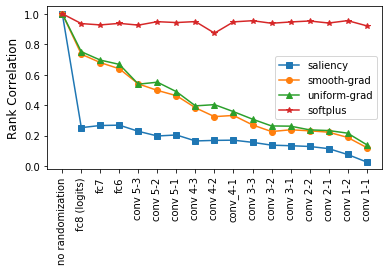

In [15]:
plt.figure(figsize=(6, 3))
plt.plot(spr_grad, label="saliency", marker="s")
plt.plot(spr_smooth_grad, label="smooth-grad", marker="o")
plt.plot(spr_uniform_grad, label="uniform-grad", marker="^")
plt.plot(spr_softplus, label="softplus", marker="*")
plt.legend()
plt.xticks(range(17), ["no randomization"] + layer_names[1:], rotation=90);
plt.ylabel("Rank Correlation", fontsize=12)
plt.savefig("spr_cascade_randomized.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

#### comparing $\sigma$ values for smooth grad

In [9]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

idx = model(x).argmax()
print(idx)

sigmas = [(torch.max(x) - torch.min(x)).item() * c for c in [0.01, 0.05, 0.1, 0.2,]]
spr_rank_grad = [1.0]
spr_rank_smooth_grad = {sigma:[1.0] for sigma in sigmas}

x_expl_grad_org = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
x_expl_sg_org = {sigma: get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu() 
                 for sigma in sigmas}
torch.cuda.empty_cache()

org_layers_to_reinit = []

for i in range(len(model.features)):
    if isinstance(model.features[i], nn.Conv2d):
        org_layers_to_reinit.append(model.features[i])
    elif isinstance(model.features[i], nn.Linear):
        org_layers_to_reinit.append(model.features[i])
    else: pass
    
for i in range(len(model.classifier)):
    if isinstance(model.classifier[i], nn.Conv2d):
        org_layers_to_reinit.append(model.classifier[i])
    elif isinstance(model.classifier[i], nn.Linear):
        org_layers_to_reinit.append(model.classifier[i])
    else: pass
org_layers_to_reinit = org_layers_to_reinit[::-1]

for i, l in enumerate(org_layers_to_reinit):
    nn.init.xavier_uniform_(l.weight)
    x_expl_grad = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
    spr_rank_grad.append(spr(x_expl_grad_org.flatten(), 
                             x_expl_grad.flatten())[0])
    del x_expl_grad
    torch.cuda.empty_cache()
    for sigma in sigmas:
        x_expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
        spr_rank_smooth_grad[sigma].append(spr(x_expl_sg_org[sigma].flatten(),
                                              x_expl_sg.flatten())[0])
        del x_expl_sg
        torch.cuda.empty_cache()
    
    
    


tensor(17, device='cuda:0')


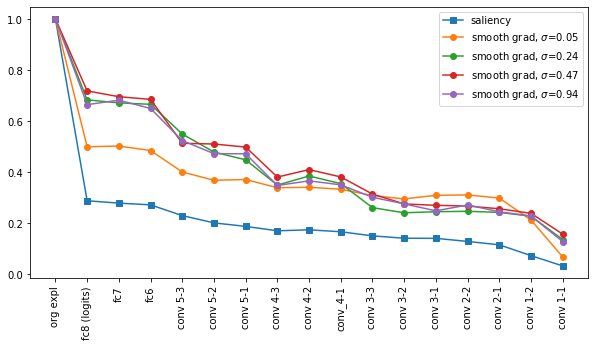

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(spr_rank_grad, label="saliency", marker="s")
for s in sigmas:
    plt.plot(spr_rank_smooth_grad[s], label="smooth grad, $\sigma$={}".format(round(s, 2)), marker="o")
plt.legend()
plt.xticks(range(17), layer_names, rotation=90);
plt.savefig("spr_cascade_randomized_sg.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

### checker board examples

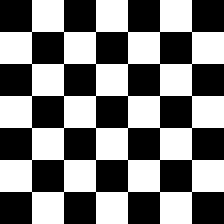

In [8]:
chess = Image.open("checkerboard.png")
chess

In [9]:
x_chess = torchvision.transforms.ToTensor()(chess).unsqueeze(0).to(device)

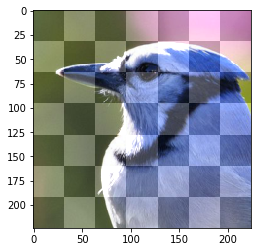

In [10]:
plt.imshow(torch_to_image(x+1*x_chess, data_mean, data_std))

In [11]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

In [14]:
idx = model(x).argmax()
print(idx)

tensor(17, device='cuda:0')


/home/ubuntu/captum/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


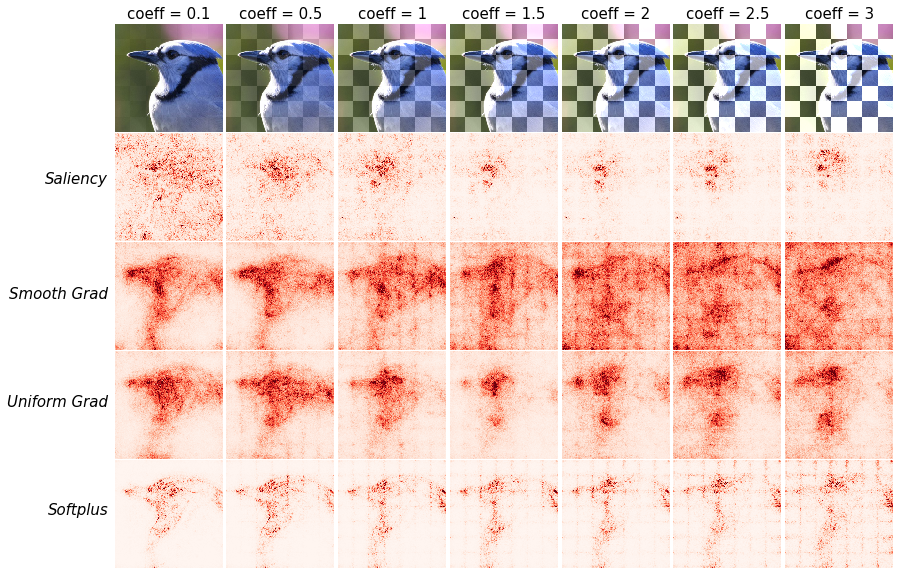

In [15]:
fig, ax = plt.subplots(5, 7, figsize=(14,10))
for i, c in enumerate([0.1, 0.5, 1, 1.5, 2, 2.5, 3]):
    ax[0, i].imshow(torch_to_image(x+c*x_chess, data_mean, data_std))
    x_expl_grad = get_expl(model, x+c*x_chess, "saliency", desired_index=idx)
    x_expl_sg = get_expl(model, x+c*x_chess, "saliency", desired_index=idx, smooth=True, sigma=sigma)
    x_expl_ug = get_expl(model, x+c*x_chess, "uniform_grad", desired_index=idx, sigma=sigma)
    viz.visualize_image_attr(np.transpose(x_expl_grad.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1, i]), use_pyplot=False)

    viz.visualize_image_attr(np.transpose(x_expl_sg.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[2, i]), use_pyplot=False)
    
    viz.visualize_image_attr(np.transpose(x_expl_ug.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[3, i]), use_pyplot=False)
########softplus###########
model = convert_relu_to_softplus(model, beta=0.8)
for i, c in enumerate([0.1, 0.5, 1, 1.5, 2, 2.5, 3]):
    x_expl_softplus = get_expl(model, x+c*x_chess, "saliency", desired_index=idx)
    viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[4, i]), use_pyplot=False)
    
for i, c in enumerate([0.1, 0.5, 1, 1.5, 2, 2.5, 3]):
    ax[0, i].set_title("coeff = {}".format(c), fontsize=15)
for i in range(5):
    for j in range(7):
        ax[i,j].axis('off')
fig.text(0.12, 0.66, 'Saliency', style = 'oblique', fontsize = 15, horizontalalignment ='right')
fig.text(0.12, 0.5, 'Smooth Grad', style = 'oblique', fontsize = 15, horizontalalignment ='right')
fig.text(0.12, 0.35, 'Uniform Grad', style = 'oblique', fontsize = 15, horizontalalignment ='right')
fig.text(0.12, 0.2, 'Softplus', style = 'oblique', fontsize = 15, horizontalalignment ='right')
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("checkerboard.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05)

### adding a small object to an image

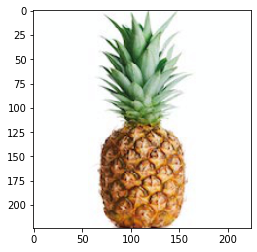

In [16]:
pineapple_img = load_image(data_mean, data_std, device, "../sample_imagenet/pineapple.jpeg")
plt.imshow(torch_to_image(pineapple_img, data_mean, data_std))

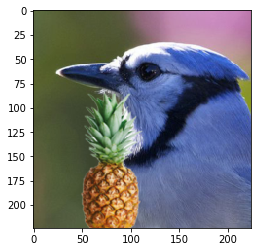

In [18]:
x_star = load_image(data_mean, data_std, device, "../sample_imagenet/sample_0_pineapple.jpg")
plt.imshow(torch_to_image(x_star, data_mean, data_std))

In [39]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

In [40]:
model(pineapple_img).argmax()

tensor(953, device='cuda:0')

In [41]:
model(x_star).argmax()

tensor(17, device='cuda:0')

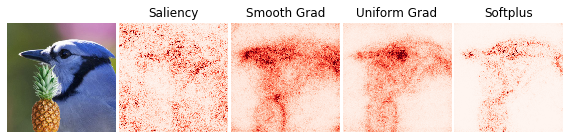

In [42]:
fig, ax = plt.subplots(1, 5, figsize=(10,2))
ax[0].imshow(torch_to_image(x_star, data_mean, data_std))

x_expl_grad = get_expl(model, x_star, "saliency", desired_index=idx).detach().cpu()
viz.visualize_image_attr(np.transpose(x_expl_grad.squeeze().numpy(), (1,2,0)),
                         np.transpose(x_star.squeeze().cpu().detach().numpy(), (1,2,0)),
                         method='heat_map',
                         cmap="Reds",
                         show_colorbar=False,
                         outlier_perc=2,
                         fig_size=(4,4), plt_fig_axis=(fig, ax[1]), use_pyplot=False)
del x_expl_grad
torch.cuda.empty_cache()

x_expl_sg = get_expl(model, x_star, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
viz.visualize_image_attr(np.transpose(x_expl_sg.squeeze().numpy(), (1,2,0)),
                         np.transpose(x_star.squeeze().cpu().detach().numpy(), (1,2,0)),
                         method='heat_map',
                         cmap="Reds",
                         show_colorbar=False,
                         outlier_perc=2,
                         fig_size=(4,4), plt_fig_axis=(fig, ax[2]), use_pyplot=False)
del x_expl_sg
torch.cuda.empty_cache()

x_expl_ug = get_expl(model, x_star, "uniform_grad", desired_index=idx, sigma=sigma).detach().cpu()
viz.visualize_image_attr(np.transpose(x_expl_ug.squeeze().cpu().detach().numpy(), (1,2,0)),
                         np.transpose(x_star.squeeze().cpu().detach().cpu().detach().numpy(), (1,2,0)),
                         method='heat_map',
                         cmap="Reds",
                         show_colorbar=False,
                         outlier_perc=2,
                         fig_size=(4,4), plt_fig_axis=(fig, ax[3]), use_pyplot=False)
del x_expl_ug
torch.cuda.empty_cache()

##########softplus###########
model = convert_relu_to_softplus(model, beta=0.8)
x_expl_softplus = get_expl(model, x_star, "saliency", desired_index=idx).detach().cpu()
viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().numpy(), (1,2,0)),
                         np.transpose(x_star.squeeze().cpu().detach().numpy(), (1,2,0)),
                         method='heat_map',
                         cmap="Reds",
                         show_colorbar=False,
                         outlier_perc=2,
                         fig_size=(4,4), plt_fig_axis=(fig, ax[4]), use_pyplot=False)
del x_expl_softplus
torch.cuda.empty_cache()

ax[1].set_title("Saliency", fontsize=12)
ax[2].set_title("Smooth Grad", fontsize=12)
ax[3].set_title("Uniform Grad", fontsize=12)
ax[4].set_title("Softplus", fontsize=12)
plt.subplots_adjust(wspace=0.01, hspace=0.01)
for i in range(5):
    ax[i].axis('off')
plt.savefig("added_object_expl.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05)

### Grad-CAM

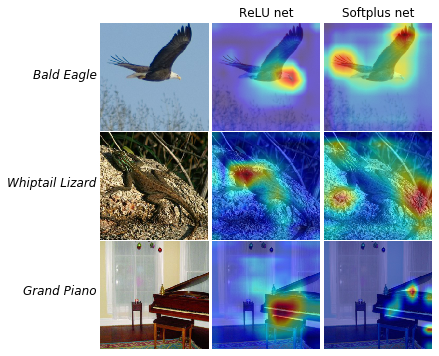

In [37]:
#grad-cam
sys.path.append("../../pytorch-grad-cam/")
from gradcam import GradCam, preprocess_image, show_cam_on_image
import cv2

model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

images = ["../sample_imagenet_1/sample_5.jpg",
#          "../sample_imagenet_1/sample_8.jpg",
#          "../sample_imagenet_1/sample_12.jpg",
          "../sample_imagenet_1/sample_11.jpg",
          "../sample_imagenet_1/sample_19.jpg",
         ]


fig, ax = plt.subplots(3, 3, figsize=(6,6))

for i, img_path in enumerate(images):
    img = load_image(data_mean, data_std, device, img_path)
    ax[i, 0].imshow(torch_to_image(img, data_mean, data_std))
    
grad_cam = GradCam(model=model, feature_module=model.features, \
                       target_layer_names=["28"], use_cuda=True)
labels = []
for i, img_path in enumerate(images):
    img = load_image(data_mean, data_std, device, img_path)
    labels.append(model(img).argmax())
    grayscale_cam = grad_cam(img)
    cam = show_cam_on_image(torch_to_image(img, data_mean, data_std), grayscale_cam)
    ax[i, 1].imshow(cam[:, :, ::-1])
    
model = convert_relu_to_softplus(model, beta=0.8)
grad_cam = GradCam(model=model, feature_module=model.features, \
                       target_layer_names=["28"], use_cuda=True)

for i, img_path in enumerate(images):
    img = load_image(data_mean, data_std, device, img_path)
    grayscale_cam = grad_cam(img, target_category=labels[i])
    cam = show_cam_on_image(torch_to_image(img, data_mean, data_std), grayscale_cam)
    ax[i, 2].imshow(cam[:, :, ::-1])
    
ax[0, 1].set_title("ReLU net", fontsize=12)
ax[0, 2].set_title("Softplus net",fontsize=12)

for i in range(3):
    for j in range(3):
        ax[i,j].axis('off')

fig.text(0.12, 0.75, 'Bald Eagle', style = 'oblique', fontsize = 12, horizontalalignment ='right')
fig.text(0.12, 0.5, 'Whiptail Lizard', style = 'oblique', fontsize = 12, horizontalalignment ='right')
fig.text(0.12, 0.25, 'Grand Piano', style = 'oblique', fontsize = 12, horizontalalignment ='right')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("gradcam_softplus.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

In [32]:
labels

[tensor(22, device='cuda:0'),
 tensor(41, device='cuda:0'),
 tensor(579, device='cuda:0')]

tensor(600, device='cuda:0')